# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


In [2]:
from __future__ import print_function, division
import matplotlib.pylab as plt
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline
%matplotlib inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20


Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
! curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy > MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  32.6M      0 --:--:-- --:--:-- --:--:-- 32.7M


In [4]:
! curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/Ridetypes.png > Ridetypes.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12802  100 12802    0     0  88705      0 --:--:-- --:--:-- --:--:-- 88902


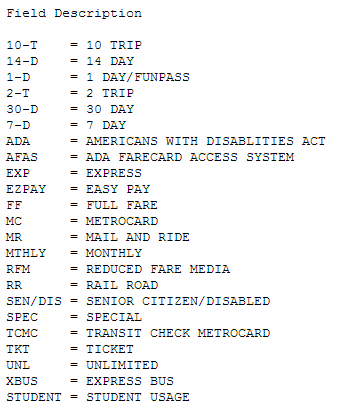

In [5]:
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [6]:
mta = np.load("MTA_Fare.npy")
mta

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

In [7]:
# replace the -1 entries with NaN
mta = mta.astype(float)
mta[mta==-1] = np.nan
mta[mta==0] = np.nan

In [8]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [9]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [10]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

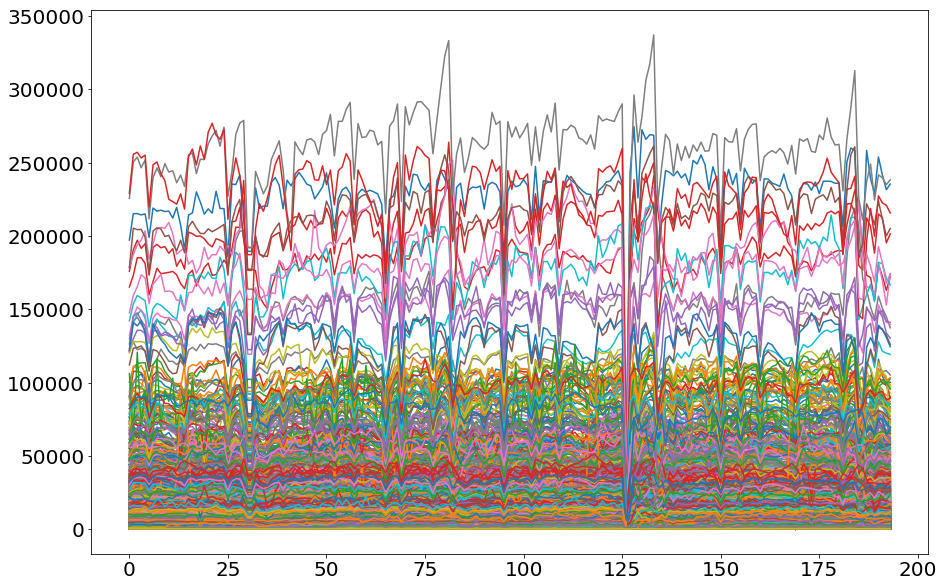

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(mta)):
    for j in range(len(mta[0])):
        ax.plot(range(0,194), mta[i][j], '-')

#### Figure 1: time series for all ride types and all stations in natural space

In [12]:
mta_log = np.log10(mta)
mta_log

array([[[ 4.75557761,  4.81092442,  4.83252169, ...,  4.562614  ,
          4.53057106,  4.56613096],
        [ 3.23854789,  3.31868927,  3.32366454, ...,  3.10174707,
          3.06892761,  3.09272064],
        [ 2.30749604,  2.44090908,  2.38916608, ...,  2.26951294,
          2.22271647,  2.22271647],
        ..., 
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  3.04960561,
          3.13893394,  2.85247999]],

       [[ 4.20978301,  4.30489964,  4.33783848, ...,         nan,
                 nan,         nan],
        [ 2.70156799,  2.81090428,  2.82282165, ...,         nan,
                 nan,         nan],
        [ 1.61278386,  1.63346846,  1.64345268, ...,         nan,
                 nan,         nan],
        ..., 
        [        nan,         nan,         nan, ...,

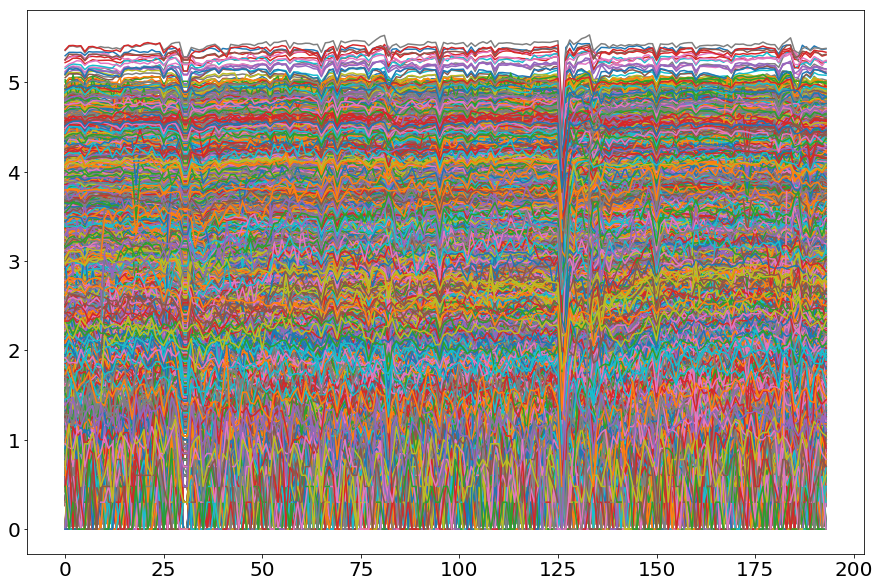

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(mta_log)):
    for j in range(len(mta_log[0])):
        ax.plot(range(0,194), mta_log[i][j], '-')

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [14]:
# sum
mta_week = np.nansum(mta,axis=0)
mta_week = np.nansum(mta_week,axis=0)
mta_week.shape

(194,)

In [15]:
# original plot

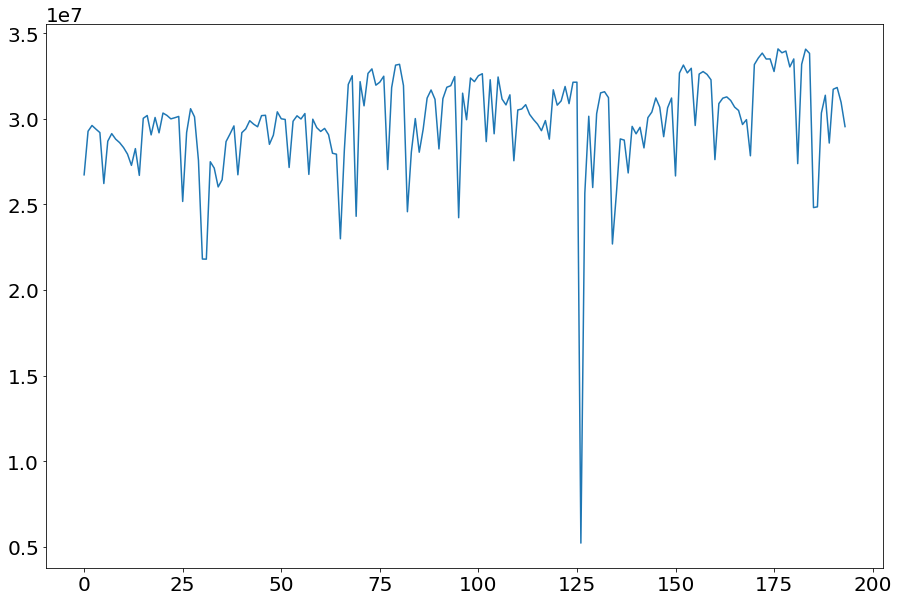

In [16]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(0,194), mta_week, '-')

In [17]:
print ("mean card swipes by day: {:.2f}".format(mta_week.mean()))
print ("stdev card swipes by day: {:.2f}".format(mta_week.std()))
thresholds = [mta_week.mean() + 3 * mta_week.std(), mta_week.mean() - 3 * mta_week.std()]
print ("3-sigma thresholds {:.2f} {:.2f}:".format(*thresholds))

mean card swipes by day: 29781349.87
stdev card swipes by day: 2983960.42
3-sigma thresholds 38733231.14 20829468.61:


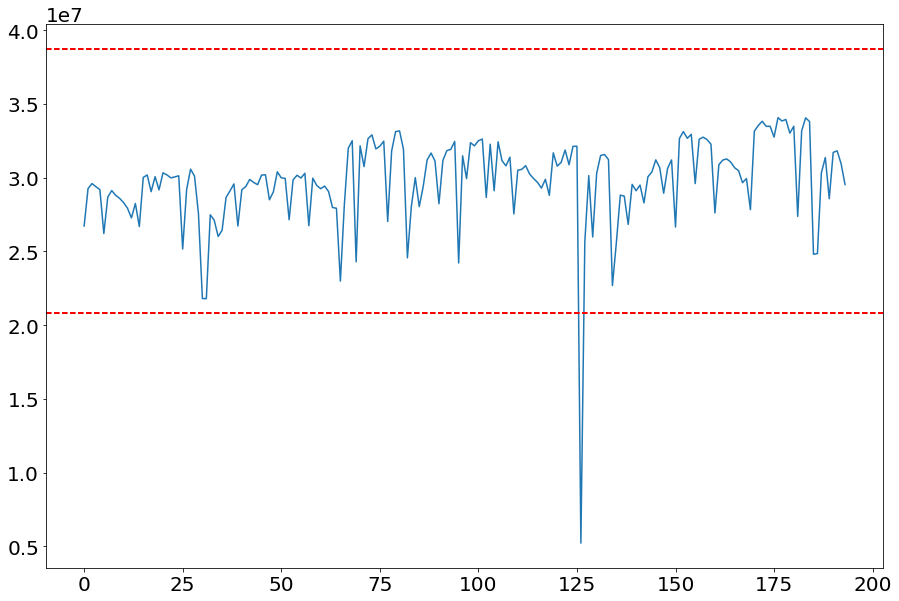

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(0,194), mta_week, '-')
plt.axhline(thresholds[0], color='r', ls='--', lw=2.0)
plt.axhline(thresholds[1], color='r', ls='--', lw=2.0)

In [19]:
mta_week[(mta_week < thresholds[1])]

array([ 5218686.])

In [20]:
np.where((mta_week < thresholds[1]))

(array([126]),)

In [21]:
pd.date_range?

In [22]:
date_range = pd.date_range('05/19/2010', '02/19/2014', freq='W' )
date_range

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-15', '2013-12-22', '2013-12-29', '2014-01-05',
               '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
               '2014-02-09', '2014-02-16'],
              dtype='datetime64[ns]', length=196, freq='W-SUN')

In [23]:
date_range[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

### The most prominent event: 

### Iterative thresholding
** What other events are significant? We can remove week 126 and look for more outliers **

In [24]:
mta_week_iterative = mta_week
mta_week_iterative[mta_week_iterative < thresholds[1]] = np.nan

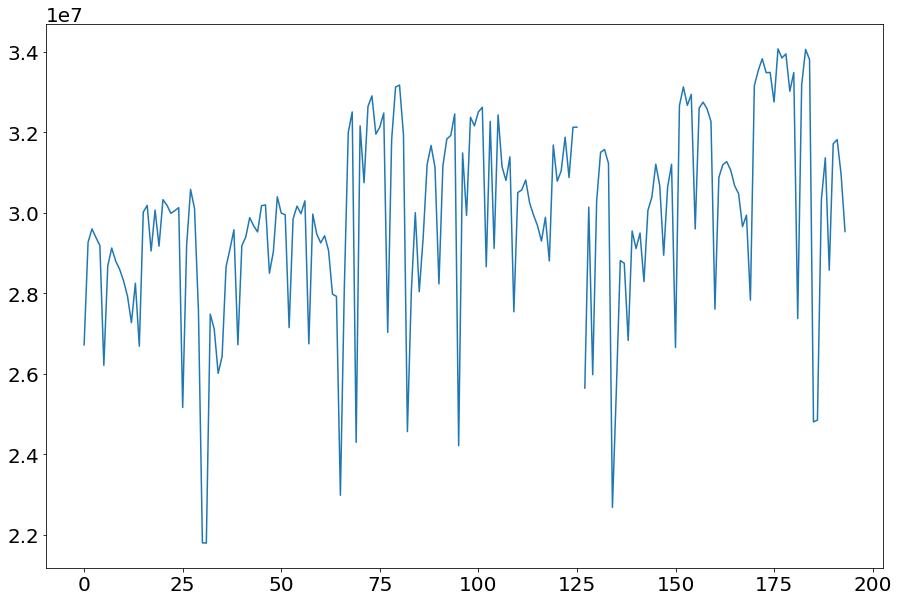

In [25]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(0,194), mta_week_iterative, '-')

In [26]:
print ("mean card swipes by day: {:.2f}".format(np.nanmean(mta_week_iterative)))
print ("stdev card swipes by day: {:.2f}".format(nanstd(mta_week_iterative)))
thresholds = [np.nanmean(mta_week_iterative) + 3 * nanstd(mta_week_iterative), np.nanmean(mta_week_iterative) - 3 * nanstd(mta_week_iterative)]
print ("3-sigma thresholds {:.2f} {:.2f}:".format(*thresholds))

mean card swipes by day: 29908617.56
stdev card swipes by day: 2409963.51
3-sigma thresholds 37138508.08 22678727.04:


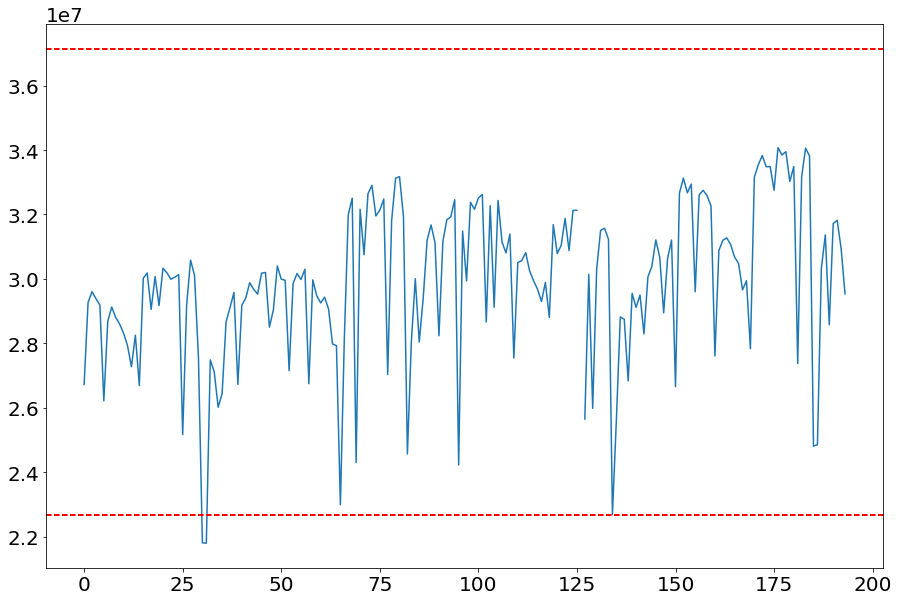

In [27]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(0,194), mta_week_iterative, '-')
plt.axhline(thresholds[0], color='r', ls='--', lw=2.0)
plt.axhline(thresholds[1], color='r', ls='--', lw=2.0)

In [28]:
mta_week_iterative[(mta_week_iterative < thresholds[1])]

array([ 21802973.,  21796368.])

In [29]:
np.where((mta_week_iterative < thresholds[1]))

(array([30, 31]),)

In [30]:
date_range[30]

Timestamp('2010-12-19 00:00:00', offset='W-SUN')

In [31]:
date_range[31]

Timestamp('2010-12-26 00:00:00', offset='W-SUN')

### the other prominent event: 

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [32]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [33]:
# natural space
mta_type = np.nansum(mta,axis=0)
mta_type.shape

(23, 194)

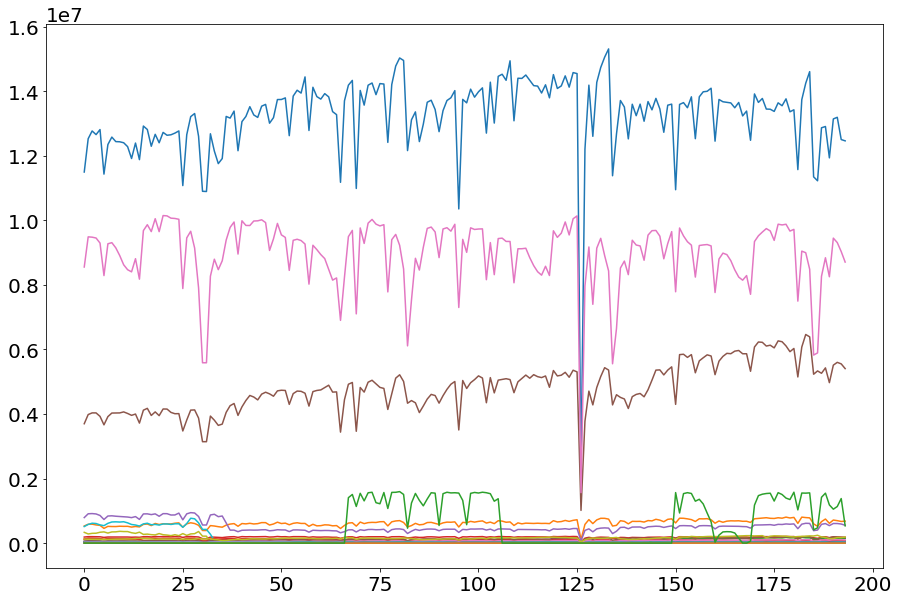

In [34]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(mta_type)):
    ax.plot(range(len(mta_type[0])), mta_type[i], '-')

In [35]:
# log space
mta_log_type = np.nansum(mta_log, axis=0)
mta_log_type.shape

(23, 194)

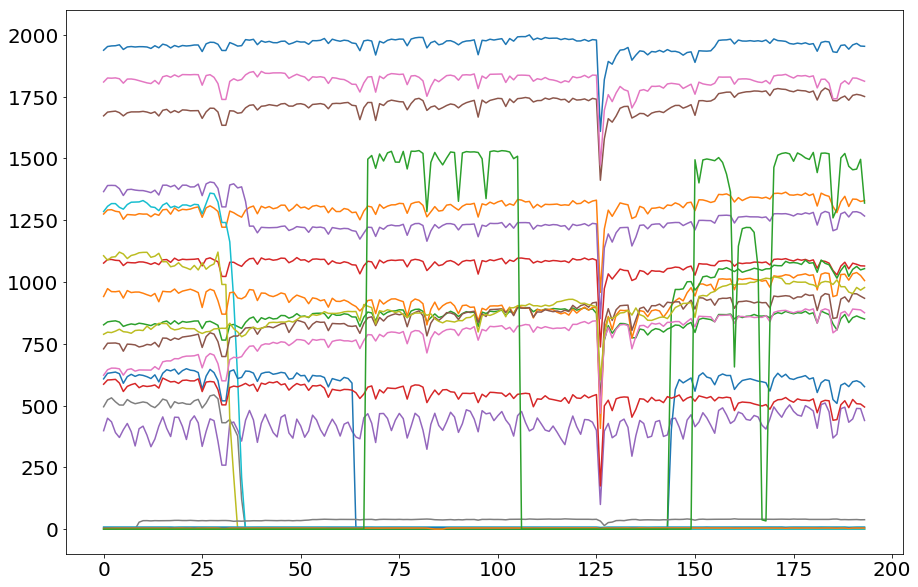

In [36]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(mta_log_type)):
    ax.plot(range(len(mta_log_type[0])), mta_log_type[i], '-')

In [37]:
df_type = pd.DataFrame(mta_type)
df_type.head()

0           1           2           3           4           5    \
0  11494615.0  12526859.0  12766627.0  12653675.0  12809694.0  11429783.0   
1    530524.0    583533.0    586194.0    562602.0    548858.0    455691.0   
2     47801.0     51486.0     51636.0     52063.0     51153.0     46852.0   
3    186551.0    199229.0    199668.0    196389.0    194883.0    175648.0   
4     46808.0     64353.0     56994.0     37429.0     35210.0     46849.0   

          6           7           8           9       ...             184  \
0  12346877.0  12576759.0  12437115.0  12431257.0     ...      14604028.0   
1    518187.0    513412.0    512192.0    522569.0     ...        781529.0   
2     48963.0     49629.0     49030.0     50376.0     ...         62658.0   
3    188467.0    188090.0    186822.0    190528.0     ...        193268.0   
4     60225.0     47439.0     32084.0     52171.0     ...         56671.0   

          185         186         187         188         189         190  \
0  11344945.0  11223430.0  12864865.0  12904811.0  11932970.0  13139360.0   
1    596341.0    518956.0    664531.0    744990.0    613294.0    713717.0   
2     50820.0     45153.0     56129.0     60429.0     51664.0     57208.0   
3    164607.0    148652.0    177885.0    193547.0    168932.0    189564.0   
4     22623.0     25301.0     67713.0     64867.0     43426.0     47804.0   

          191         192         193  
0  13189610.0  12500756.0  12459947.0  
1    695134.0    670228.0    679497.0  
2     58771.0     56525.0     55192.0  
3    184239.0    180029.0    179363.0  
4     61101.0     59400.0     46859.0  

[5 rows x 194 columns]

In [38]:
df_type_rmean = pd.DataFrame()
for i in range(23):
    df_type_rmean[i] = pd.rolling_mean(df_type.irow(i), 10, center=True)
df_type_rmean.head(10)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=True).mean()
  app.launch_new_instance()


0         1        2         3        4          5          6   \
0         NaN       NaN      NaN       NaN      NaN        NaN        NaN   
1         NaN       NaN      NaN       NaN      NaN        NaN        NaN   
2         NaN       NaN      NaN       NaN      NaN        NaN        NaN   
3         NaN       NaN      NaN       NaN      NaN        NaN        NaN   
4         NaN       NaN      NaN       NaN      NaN        NaN        NaN   
5  12347326.1  533376.2  49898.9  190627.5  47956.2  3934303.6  9117571.2   
6  12438021.8  532186.0  50014.6  190856.4  48741.4  3970926.0  9124481.8   
7  12413400.0  525801.8  49727.9  189699.8  46724.4  3974298.6  9022678.5   
8  12328087.8  516787.3  49310.8  187936.9  43959.0  3966722.6  8915251.8   
9  12301901.5  511925.8  49105.8  186858.1  43932.1  3963185.5  8851225.3   

        7         8         9  ...         13        14       15       16  \
0      NaN       NaN       NaN ...        NaN       NaN      NaN      NaN   
1      NaN       NaN       NaN ...        NaN       NaN      NaN      NaN   
2      NaN       NaN       NaN ...        NaN       NaN      NaN      NaN   
3      NaN       NaN       NaN ...        NaN       NaN      NaN      NaN   
4      NaN       NaN       NaN ...        NaN       NaN      NaN      NaN   
5  10981.3  327499.7  599218.7 ...   137296.4  844028.3  64516.0  31208.6   
6  11057.6  329921.7  614143.4 ...   138431.2  846704.1  64826.2  31525.9   
7  10942.7  337337.3  619018.1 ...   136185.4  836627.0  64197.5  31426.6   
8  10725.4  339234.3  615071.9 ...   133147.9  824119.7  63383.3  31322.8   
9  10580.2  338819.6  610441.1 ...   131111.0  815964.5  63007.3  31417.4   

       17        18       19      20     21   22  
0     NaN       NaN      NaN     NaN    NaN  NaN  
1     NaN       NaN      NaN     NaN    NaN  NaN  
2     NaN       NaN      NaN     NaN    NaN  NaN  
3     NaN       NaN      NaN     NaN    NaN  NaN  
4     NaN       NaN      NaN     NaN    NaN  NaN  
5   454.0  120860.6  21131.1  6626.3  476.2  0.0  
6  1740.9  120940.9  21176.8  6756.1  489.8  0.0  
7  3128.6  121945.7  21167.9  6878.3  489.0  0.0  
8  4197.9  122751.3  21167.1  6934.6  480.1  0.0  
9  5515.0  124538.5  21173.3  6963.0  477.8  0.0  

[10 rows x 23 columns]

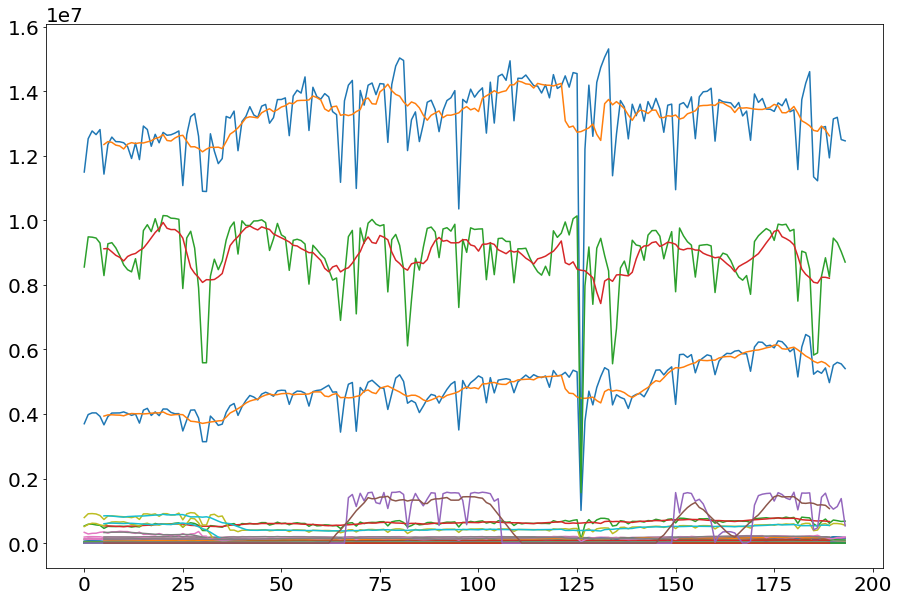

In [39]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(mta_type)):
    ax.plot(range(len(mta_type[0])), mta_type[i], '-', label="original")
    ax.plot(range(len(mta_type[10])), df_type_rmean[i], '-', label="rolling mean")

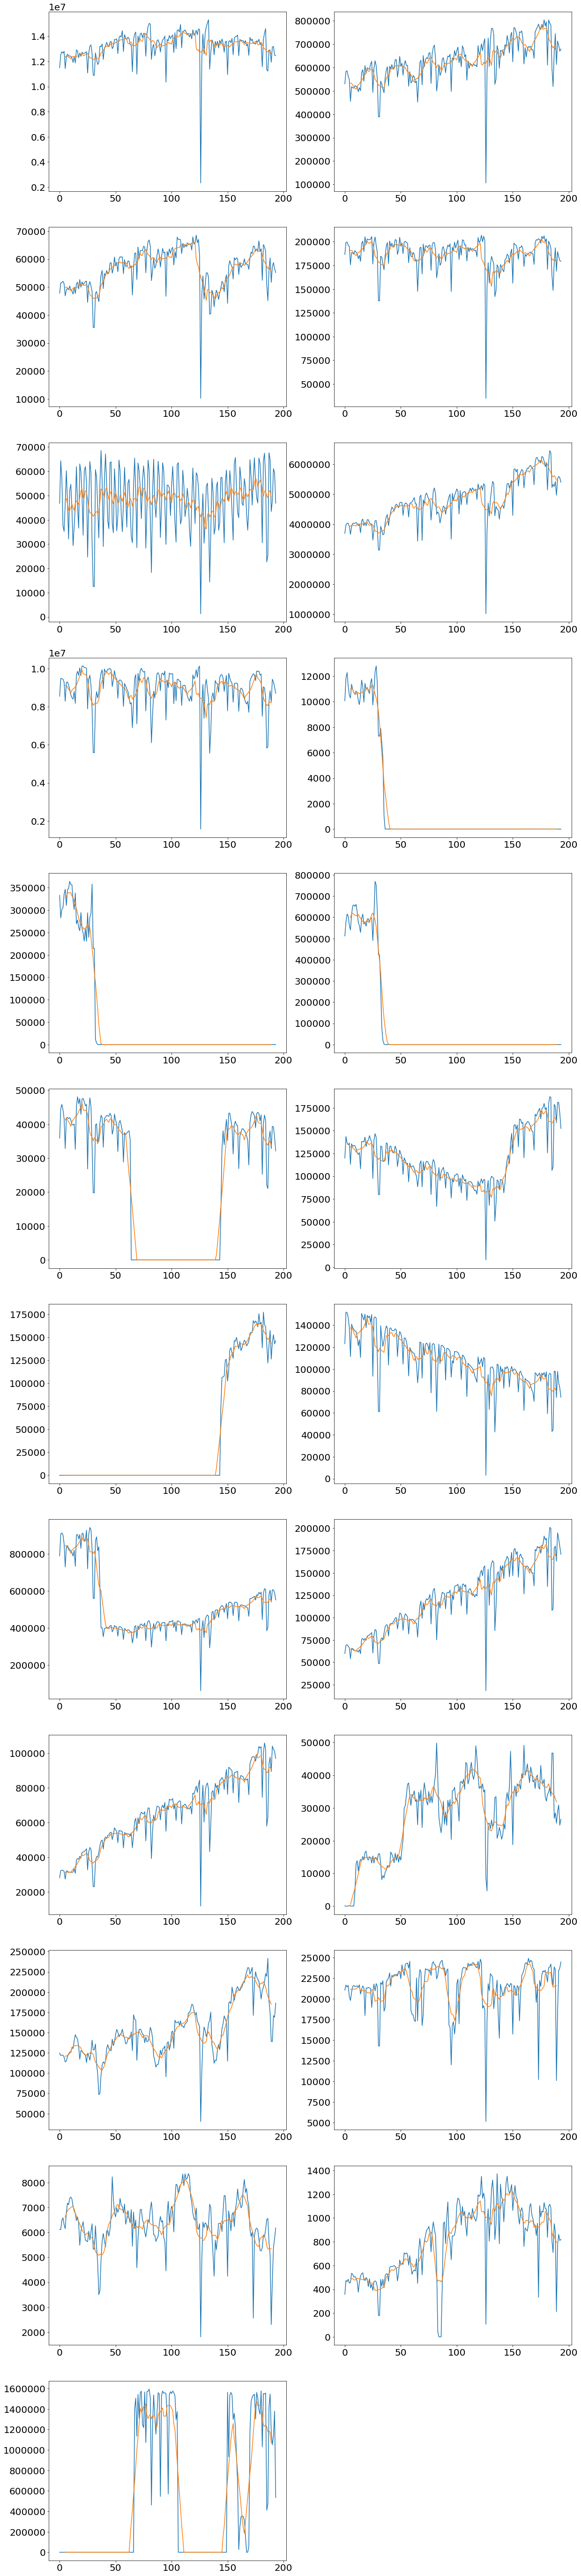

In [40]:
fig = plt.figure(figsize=(20,100))
for i in range(23):
    ax = fig.add_subplot(12,2,i+1)
    ax.plot(range(len(mta_type[0])), mta_type[i], '-', label="original")
    ax.plot(range(len(mta_type[10])), df_type_rmean[i], '-', label="rolling mean")

In [41]:
stdev = []
ratio = []

for i in range(len(mta_type)):
    stdev1 = 0
    ratio1 = 0
    
    stdev1 = nanstd(mta_type[i])
    ratio1 = mta_type[i][193]/mta_type[i][0]
    
    stdev.append(stdev1)
    ratio.append(ratio1)
    
    print("type number: %.0f" %i)
    print("stdev %f" %stdev1)
    print("fractional change over time: %f"%ratio1)
    print()

type number: 0
stdev 1212509.303711
fractional change over time: 1.083981

type number: 1
stdev 90631.594000
fractional change over time: 1.280804

type number: 2
stdev 7599.227413
fractional change over time: 1.154620

type number: 3
stdev 17590.591686
fractional change over time: 0.961469

type number: 4
stdev 12633.837135
fractional change over time: 1.001090

type number: 5
stdev 763049.861181
fractional change over time: 1.461842

type number: 6
stdev 1053449.593311
fractional change over time: 1.017916

type number: 7
stdev 4061.960231
fractional change over time: 0.000000

type number: 8
stdev 110873.907982
fractional change over time: 0.000009

type number: 9
stdev 221304.421975
fractional change over time: 0.000002

type number: 10
stdev 19630.514102
fractional change over time: 0.895259

type number: 11
stdev 29656.855316
fractional change over time: 1.270944

type number: 12
stdev 63142.328345
fractional change over time: 36588.250000

type number: 13
stdev 23741.907839
frac

In [42]:
stdev = np.asarray(stdev)

In [43]:
max(stdev)

1212509.3037106844

In [44]:
np.where(stdev==max(stdev))

(array([0]),)

In [45]:
ratio
ratio = np.asarray(ratio)
type(ratio)

numpy.ndarray

In [46]:
where_are_inf = np.isinf(ratio)
ratio[where_are_inf] = 0

In [47]:
max(ratio)

36588.25

In [48]:
np.where((ratio==max(ratio)))

(array([12]),)

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [137]:
mta = np.load("MTA_Fare.npy")

# replace the -1 entries with NaN
mta = mta.astype(float)
mta[mta==-1] = np.nan

In [138]:
mta.flatten().shape

(2677200,)

In [140]:
# reshape
mta_reshape = mta.reshape(600*23,194)
print(mta_reshape.shape)
mta_reshape

(13800, 194)


array([[ 56961.,  64703.,  68002., ...,  36527.,  33929.,  36824.],
       [  1732.,   2083.,   2107., ...,   1264.,   1172.,   1238.],
       [   203.,    276.,    245., ...,    186.,    167.,    167.],
       ..., 
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])

In [141]:
mta_reshape = pd.DataFrame(mta_reshape)
print(mta_reshape.shape)
mta_reshape.head()

(13800, 194)


0        1        2        3        4        5        6        7    \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

       8        9     ...         184      185      186      187      188  \
0  73801.0  72517.0   ...     43608.0  44774.0  46955.0  39050.0  37384.0   
1   2031.0   1980.0   ...      1425.0   1085.0    965.0   1284.0   1407.0   
2    258.0    264.0   ...       217.0    189.0    150.0    194.0    183.0   
3    907.0    907.0   ...       576.0    460.0    388.0    517.0    593.0   
4    192.0    414.0   ...       290.0    109.0    124.0    349.0    357.0   

       189      190      191      192      193  
0  33864.0  38358.0  36527.0  33929.0  36824.0  
1   1085.0   1389.0   1264.0   1172.0   1238.0  
2    185.0    200.0    186.0    167.0    167.0  
3    498.0    538.0    545.0    516.0    489.0  
4    197.0    220.0    281.0    309.0    245.0  

[5 rows x 194 columns]

In [142]:
mta_reshape_value = mta_reshape.dropna(how='any').values
print(mta_reshape_value.shape)
mta_reshape_value

(9174, 194)


array([[ 3292.,  3429.,  3629., ...,  3746.,  3406.,  3217.],
       [  110.,    92.,   102., ...,   212.,   209.,   211.],
       [    7.,     6.,    13., ...,    26.,    20.,    22.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [143]:
# sorted by station
mta_station = np.nansum(mta,axis=1)
mta_station.shape

(600, 194)

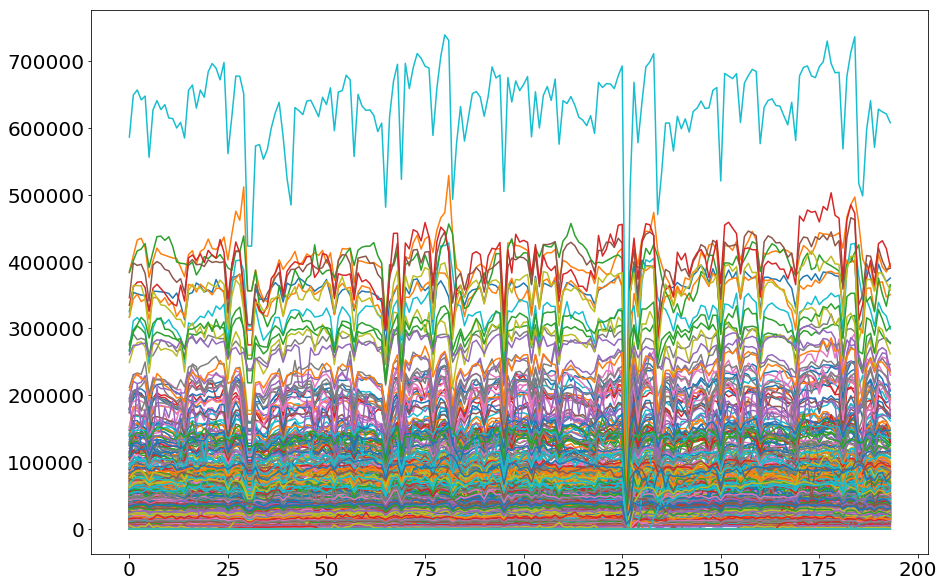

In [144]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(mta_station)):
    ax.plot(range(len(mta_station[0])), mta_station[i], '-')

In [145]:
label[:26]

array([[ 3292.,  3429.,  3629., ...,  3746.,  3406.,  3217.],
       [  110.,    92.,   102., ...,   212.,   209.,   211.],
       [    7.,     6.,    13., ...,    26.,    20.,    22.],
       ..., 
       [ 5297.,  5683.,  5716., ...,  5112.,  5035.,  4942.],
       [   48.,    61.,    70., ...,   102.,   105.,    79.],
       [  317.,   364.,   375., ...,   210.,   183.,   187.]])

In [146]:
# Calculate the mean for each time series and by station
stationsmeans = np.nanmean(mta_station, axis=1)
print(stationsmeans.shape)
stationsmeans

(600,)


array([  1.19380969e+05,   2.06625155e+04,   7.24413918e+03,
         1.90176340e+04,   2.03715670e+04,   2.22706753e+04,
         1.38575619e+04,   1.28940722e+04,   1.13197990e+04,
         1.91203376e+05,   3.56733423e+05,   3.49854330e+05,
         1.08266397e+05,   1.84694351e+05,   1.25090196e+05,
         4.32336701e+04,   1.83743299e+05,   2.76968418e+05,
         8.91681289e+04,   3.23156686e+05,   2.15042649e+05,
         4.04874660e+05,   2.87989675e+05,   1.10743299e+05,
         1.66405021e+05,   2.57731959e-02,   1.33484918e+05,
         1.31936485e+05,   2.80386716e+05,   1.18023521e+05,
         1.93084701e+05,   1.89762361e+05,   3.90171495e+05,
         4.48527732e+04,   1.36183670e+05,   2.84681082e+04,
         3.21657784e+04,   1.07197887e+04,   2.81359072e+04,
         4.34656495e+04,   1.09435381e+05,   2.48247165e+04,
         1.24495407e+05,   1.93115149e+05,   1.29016778e+05,
         3.95005804e+05,   2.18560634e+05,   5.81991443e+04,
         1.30195144e+05,

In [147]:
# Calculate the standard deviation for each time series and by station
stationsstd = np.nanstd(mta_station, axis=1)
print(stationsstd.shape)
stationsstd

(600,)


array([  3.70051584e+04,   1.86536467e+04,   9.79480615e+02,
         3.15566291e+03,   2.44516544e+03,   2.79784318e+03,
         1.61592230e+03,   2.08279861e+03,   1.40126686e+03,
         2.67309929e+04,   3.22376605e+04,   3.31209595e+04,
         1.24747975e+04,   2.27645195e+04,   2.04821563e+04,
         5.39565607e+03,   2.65697547e+04,   3.05259903e+04,
         9.09494506e+03,   3.87012115e+04,   2.40438425e+04,
         4.01395398e+04,   2.62589685e+04,   1.06831857e+04,
         1.81458911e+04,   1.58458002e-01,   1.82286439e+04,
         2.58560229e+04,   3.52613845e+04,   2.38444240e+04,
         1.98476083e+04,   2.47583834e+04,   3.92857897e+04,
         5.22657292e+03,   1.57191571e+04,   1.27136959e+04,
         5.98358513e+03,   1.97944022e+03,   5.97353075e+03,
         5.56899495e+03,   1.69439562e+04,   6.30840352e+03,
         1.68107118e+04,   2.69853722e+04,   1.66086219e+04,
         4.01770341e+04,   2.72117207e+04,   7.95879967e+03,
         1.37867611e+04,

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [148]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
print(stationid[mta.reshape(600*23, 194).std(1) > 0].shape)
stationid[mta.reshape(600*23, 194).std(1) > 0]

(7660,)


array([  2,   2,   2, ..., 550, 550, 550])

In [ ]:
tots = mta.reshape....
tots.shape

In [ ]:
normed_time_series_mean = ...
normed_time_series_std = ...

In [ ]:
normed_time_series_std[:10]

In [ ]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



In [ ]:
tsmean[:10]

In [ ]:
tsstdev[:10]


In [ ]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [ ]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [ ]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

In [ ]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [ ]:
clf = rfc()...

and use sklearn confusion_matrix to see the errors

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [ ]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred, target_names=ridetype))